# CRISPR screen to identify genetic interactions that alter the cellular phenotypes of cells that have lost DSCC1.

To run the QC for this screen, you will first need to clone the `CRISPR screen` directory from the [GitHub repository](https://github.com/team113sanger/Large-scale-analysis-of-genes-that-regulate-micronucleus-formation).

***

## Set up dependencies

In [1]:
# Load dependencies
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(GGally))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(ggridges))
suppressPackageStartupMessages(library(effsize))
suppressPackageStartupMessages(library(pROC))

# Set plot dimensions
options(repr.plot.width = 16, repr.plot.height = 12)

# Set palette
sample_type_palette <- brewer.pal(3, 'Set1')
names(sample_type_palette) <- c('Plasmid', 'WT', 'DSCC1')

*** 

## Sample metadata

Sample metadata (e.g. internal/external accessions, plot labels, number of reads) can be found in `METADATA/sample_metadata.tsv`. It contains information by sequencing lane.

In [2]:
# Read in lane metadata
lane_metadata <- read.delim('METADATA/sample_metadata.tsv', sep = "\t", header = T)

# Print lane metadata
lane_metadata

sanger_sample_id,sample_name,sample_label,sample_group,ena_sample_accession,run,lane,tag,num_reads
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>
4402STDY6879625,Neo_IRES_plasmid,Plasmid,Plasmid,ERS2057919,22552,1,-,203334681
4402STDY6879625,Neo_IRES_plasmid,Plasmid,Plasmid,ERS2057919,22552,2,-,203779473
4402STDY7007016,Dcss1H06_screenA_v2,DSCC1 screen A,DSCC1,ERS2057920,23197,1,1,26039515
4402STDY7007016,Dcss1H06_screenA_v2,DSCC1 screen A,DSCC1,ERS2057920,23197,2,1,25923690
4402STDY7007017,Dcss1H06_screenB_v2,DSCC1 screen B,DSCC1,ERS2057921,23197,1,2,23607696
4402STDY7007017,Dcss1H06_screenB_v2,DSCC1 screen B,DSCC1,ERS2057921,23197,2,2,23499774
4402STDY7007018,Dcss1H06_screenC_v2,DSCC1 screen C,DSCC1,ERS2057922,23197,1,3,28400351
4402STDY7007018,Dcss1H06_screenC_v2,DSCC1 screen C,DSCC1,ERS2057922,23197,2,3,28310181
4402STDY7016117,BOB_screenA,WT screen A,WT,ERS2057923,23197,1,6,22685348


Summarise the sample metadata (including number of reads) at the sample level.

In [3]:
# Summarise metadata by sample
sample_metadata <- lane_metadata |> 
    group_by(sanger_sample_id, sample_name, sample_group, sample_label, ena_sample_accession) |>
    summarise(total_reads = sum(num_reads), .groups = 'keep') |>
    ungroup()

# Set order of samples for plots
sample_metadata$sample_group <- factor(sample_metadata$sample_group, 
                                       levels = c('Plasmid', 'WT', 'DSCC1'))

# Print sample metadata
sample_metadata

sanger_sample_id,sample_name,sample_group,sample_label,ena_sample_accession,total_reads
<chr>,<chr>,<fct>,<chr>,<chr>,<int>
4402STDY6879625,Neo_IRES_plasmid,Plasmid,Plasmid,ERS2057919,407114154
4402STDY7007016,Dcss1H06_screenA_v2,DSCC1,DSCC1 screen A,ERS2057920,51963205
4402STDY7007017,Dcss1H06_screenB_v2,DSCC1,DSCC1 screen B,ERS2057921,47107470
4402STDY7007018,Dcss1H06_screenC_v2,DSCC1,DSCC1 screen C,ERS2057922,56710532
4402STDY7016117,BOB_screenA,WT,WT screen A,ERS2057923,45276397
4402STDY7016118,BOB_screenB,WT,WT screen B,ERS2057924,46019093
4402STDY7016119,BOB_screenC,WT,WT screen C,ERS2057925,42828627


***

## Raw read counts

The raw read count matrix has been provided in `raw_count_matrix.tsv`. 

In [4]:
# Read in raw counts
raw_counts <- read.delim('raw_count_matrix.tsv', sep = "\t", header = T)

# Print first 3 rows
head(raw_counts, 3)

,sgRNA,gene,BOB_screenA,BOB_screenB,BOB_screenC,Dcss1H06_screenA_v2,Dcss1H06_screenB_v2,Dcss1H06_screenC_v2,Neo_IRES_plasmid
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,A1BG_CCDS12976.1_ex3_19:58862927-58862950:-_5-1,A1BG,538,366,304,180,632,556,3810
2,A1BG_CCDS12976.1_ex4_19:58863655-58863678:+_5-2,A1BG,319,419,171,407,296,312,3148
3,A1BG_CCDS12976.1_ex4_19:58863697-58863720:-_5-3,A1BG,486,234,588,534,796,656,5046


Once the count matrix is read in, we update the sample names using the sample labels provided in `sample_metadata`.

In [5]:
# Rename columns from sample name to sample label
names(raw_counts)[3:9] <- sample_metadata$sample_label[match(names(raw_counts)[3:9], sample_metadata$sample_name)]

# Print reheadered raw counts
head(raw_counts,3)

,sgRNA,gene,WT screen A,WT screen B,WT screen C,DSCC1 screen A,DSCC1 screen B,DSCC1 screen C,Plasmid
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,A1BG_CCDS12976.1_ex3_19:58862927-58862950:-_5-1,A1BG,538,366,304,180,632,556,3810
2,A1BG_CCDS12976.1_ex4_19:58863655-58863678:+_5-2,A1BG,319,419,171,407,296,312,3148
3,A1BG_CCDS12976.1_ex4_19:58863697-58863720:-_5-3,A1BG,486,234,588,534,796,656,5046


## Summarise library

Here we look at summarising the number of guides, number of genes and number of non-targeting control guides.

In [6]:
# Get total number of guides
num_guides <- nrow(raw_counts)
print(paste("Number of guides:", num_guides))

# Get total number of non-targeting controls
num_control_guides <- raw_counts |> 
    filter(grepl('NON-TARGETING', gene)) |>
    nrow()
print(paste("Number of guides:", num_control_guides))

# Get total number of genes (excluding controls)
num_genes <- raw_counts |> 
    filter(!grepl('NON-TARGETING', gene)) |>
    pull(gene) |> unique() |> length()
print(paste("Number of genes (excl. controls):", num_genes))

[1] "Number of guides: 101090"
[1] "Number of guides: 1004"
[1] "Number of genes (excl. controls): 18025"


***

## Sequencing statistics 

Here, we calculate and plot the following sequencing statistics:

* total number of reads per sample (`total_reads`)
* number of reads mapped to a guide (`mapped_reads`)
* number of reads which could not be assigned to a guide (`unmapped_reads`)

In [7]:
# Calculate total counts per sample, add total reads and determine unmapped reads
seq_stats <- raw_counts |>
    gather(sample_label, counts, -sgRNA, -gene) |>
    group_by(sample_label) |>
    summarise('mapped_reads' = sum(counts), .groups = 'keep') |>
    left_join(sample_metadata |> 
                  select(sample_label, sample_group, total_reads), 
              by = 'sample_label') |>
    mutate('unmapped_reads' = total_reads - mapped_reads) |>
    select(sample_label, sample_group, total_reads, mapped_reads, unmapped_reads) |>
    ungroup()

# Set order of samples for plots
seq_stats$sample_group <- factor(seq_stats$sample_group, 
                                          levels = c('Plasmid', 'WT', 'DSCC1'))

# Show summary statistics
seq_stats

sample_label,sample_group,total_reads,mapped_reads,unmapped_reads
<chr>,<fct>,<int>,<int>,<int>
DSCC1 screen A,DSCC1,51963205,46084284,5878921
DSCC1 screen B,DSCC1,47107470,41480729,5626741
DSCC1 screen C,DSCC1,56710532,49844705,6865827
Plasmid,Plasmid,407114154,365151667,41962487
WT screen A,WT,45276397,39103705,6172692
WT screen B,WT,46019093,39934889,6084204
WT screen C,WT,42828627,37214522,5614105


### Total reads per sample

Here we plot the total number of reads for each sample, grouped by condition.

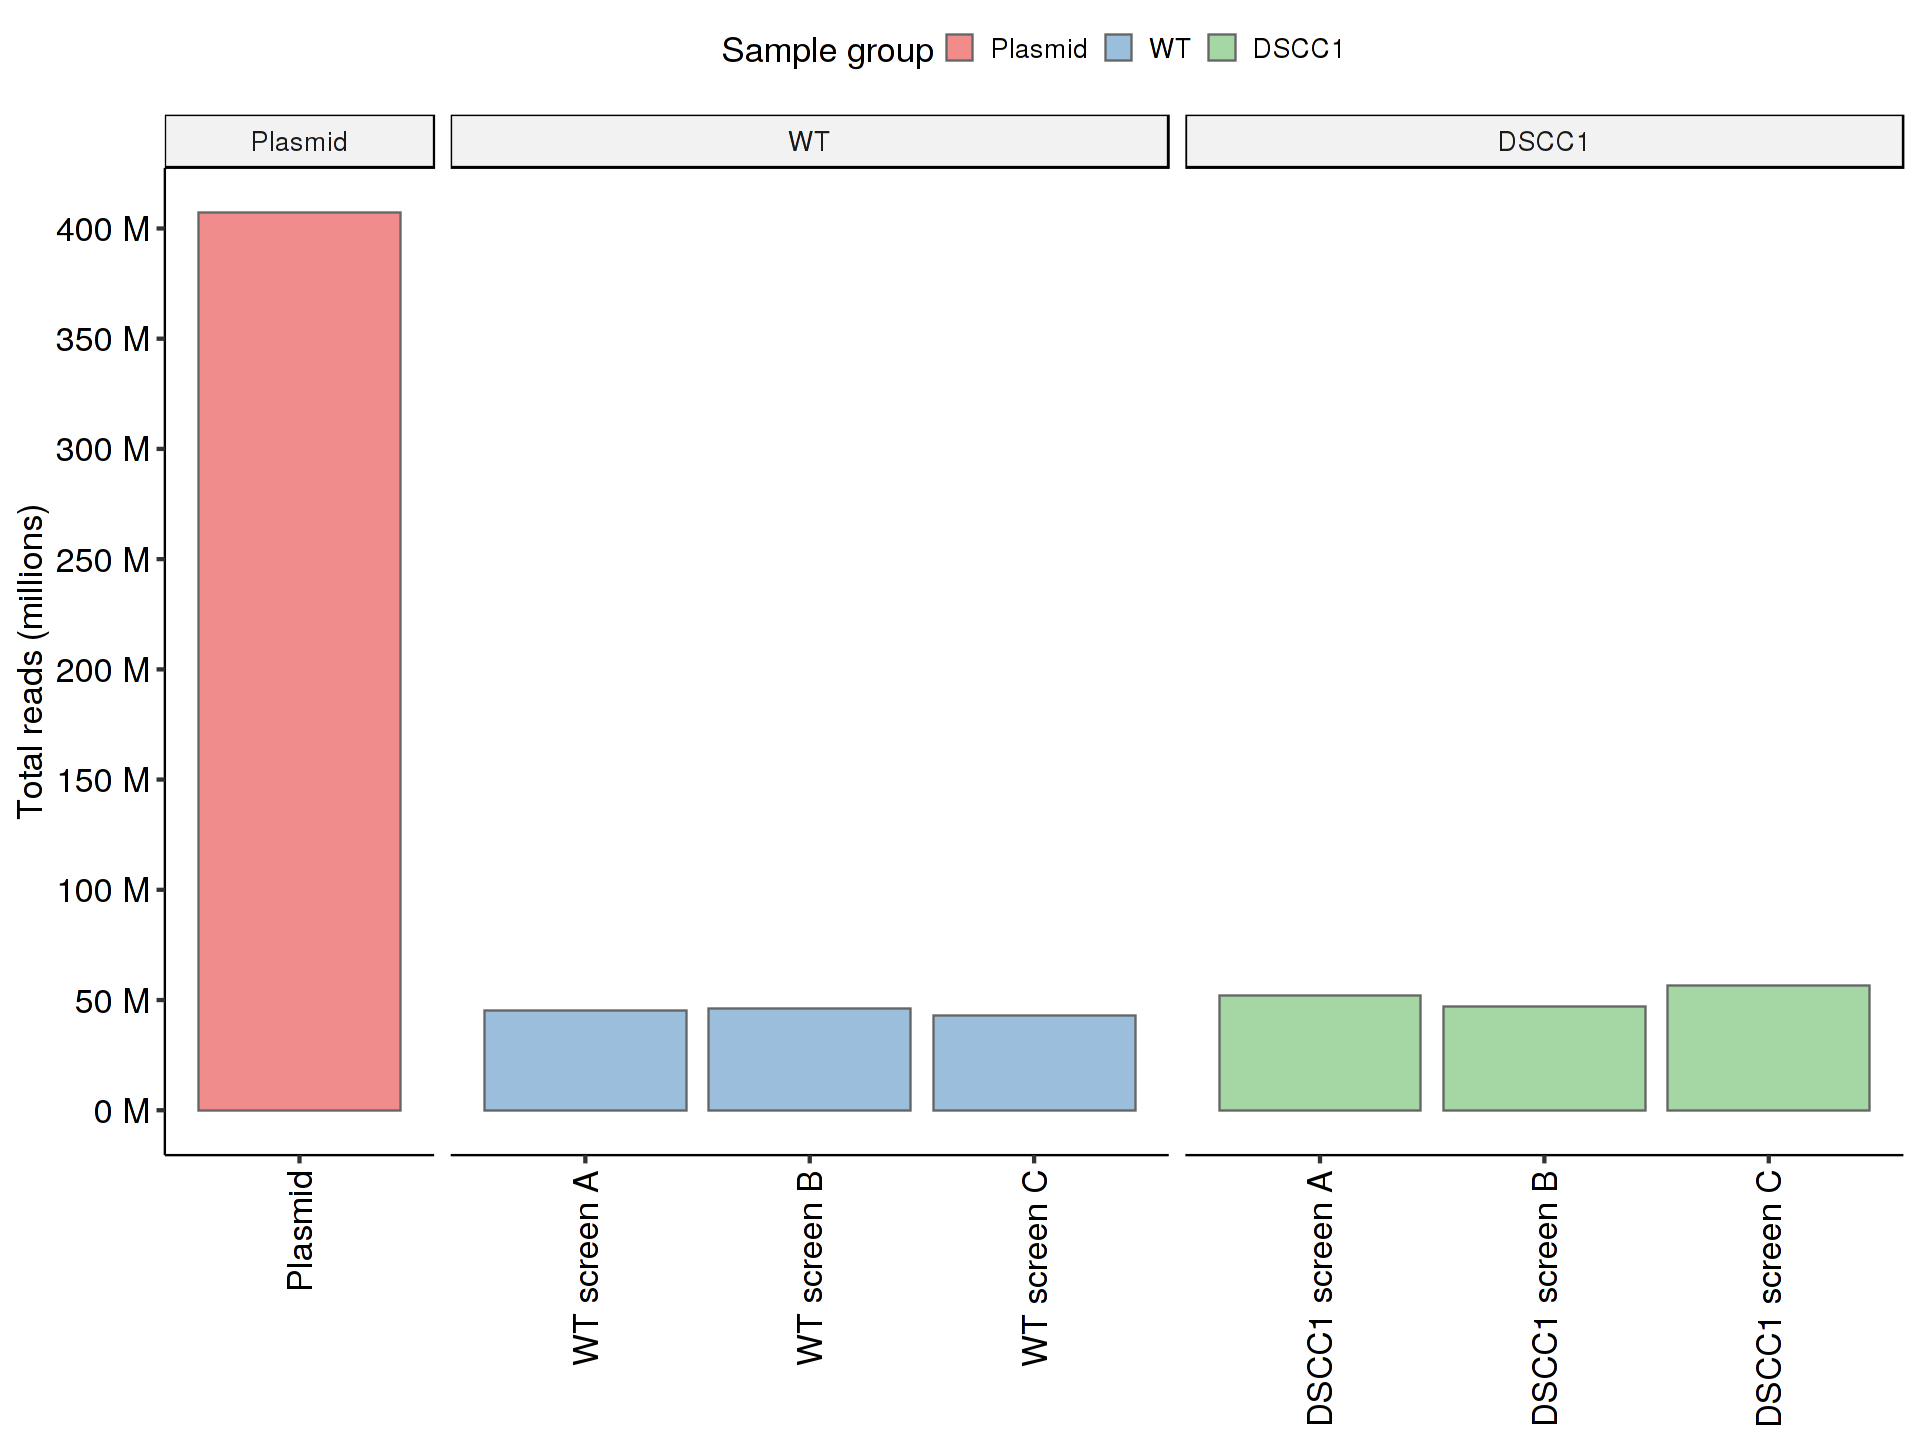

In [8]:
# Plot total reads per sample
total_reads_barplot <-
    ggplot(seq_stats, 
           aes(x = sample_label, y = total_reads, fill = sample_group)) +
        geom_col(color = 'gray40', alpha = 0.5) +
        scale_y_continuous(labels = unit_format(unit = "M", scale = 1e-6), 
                           breaks = pretty_breaks(10)) +
        scale_fill_manual(name = 'Sample group', values = sample_type_palette) +
        facet_grid(. ~ sample_group, scales = 'free_x', space = 'free_x') +
        ylab('Total reads (millions)') +
        theme_pubr(base_size = 20) +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
              axis.title.x = element_blank()) 

# Save plot
ggsave(filename = 'plots/total_reads_per_sample.png', plot = total_reads_barplot,
       device = 'png', width = 10, height = 8, dpi = 200)

# Show plot
total_reads_barplot

### Mapped vs unmapped reads

Stacked barplot comparing the number of mapped and unmapped reads per sample grouped by sample type.

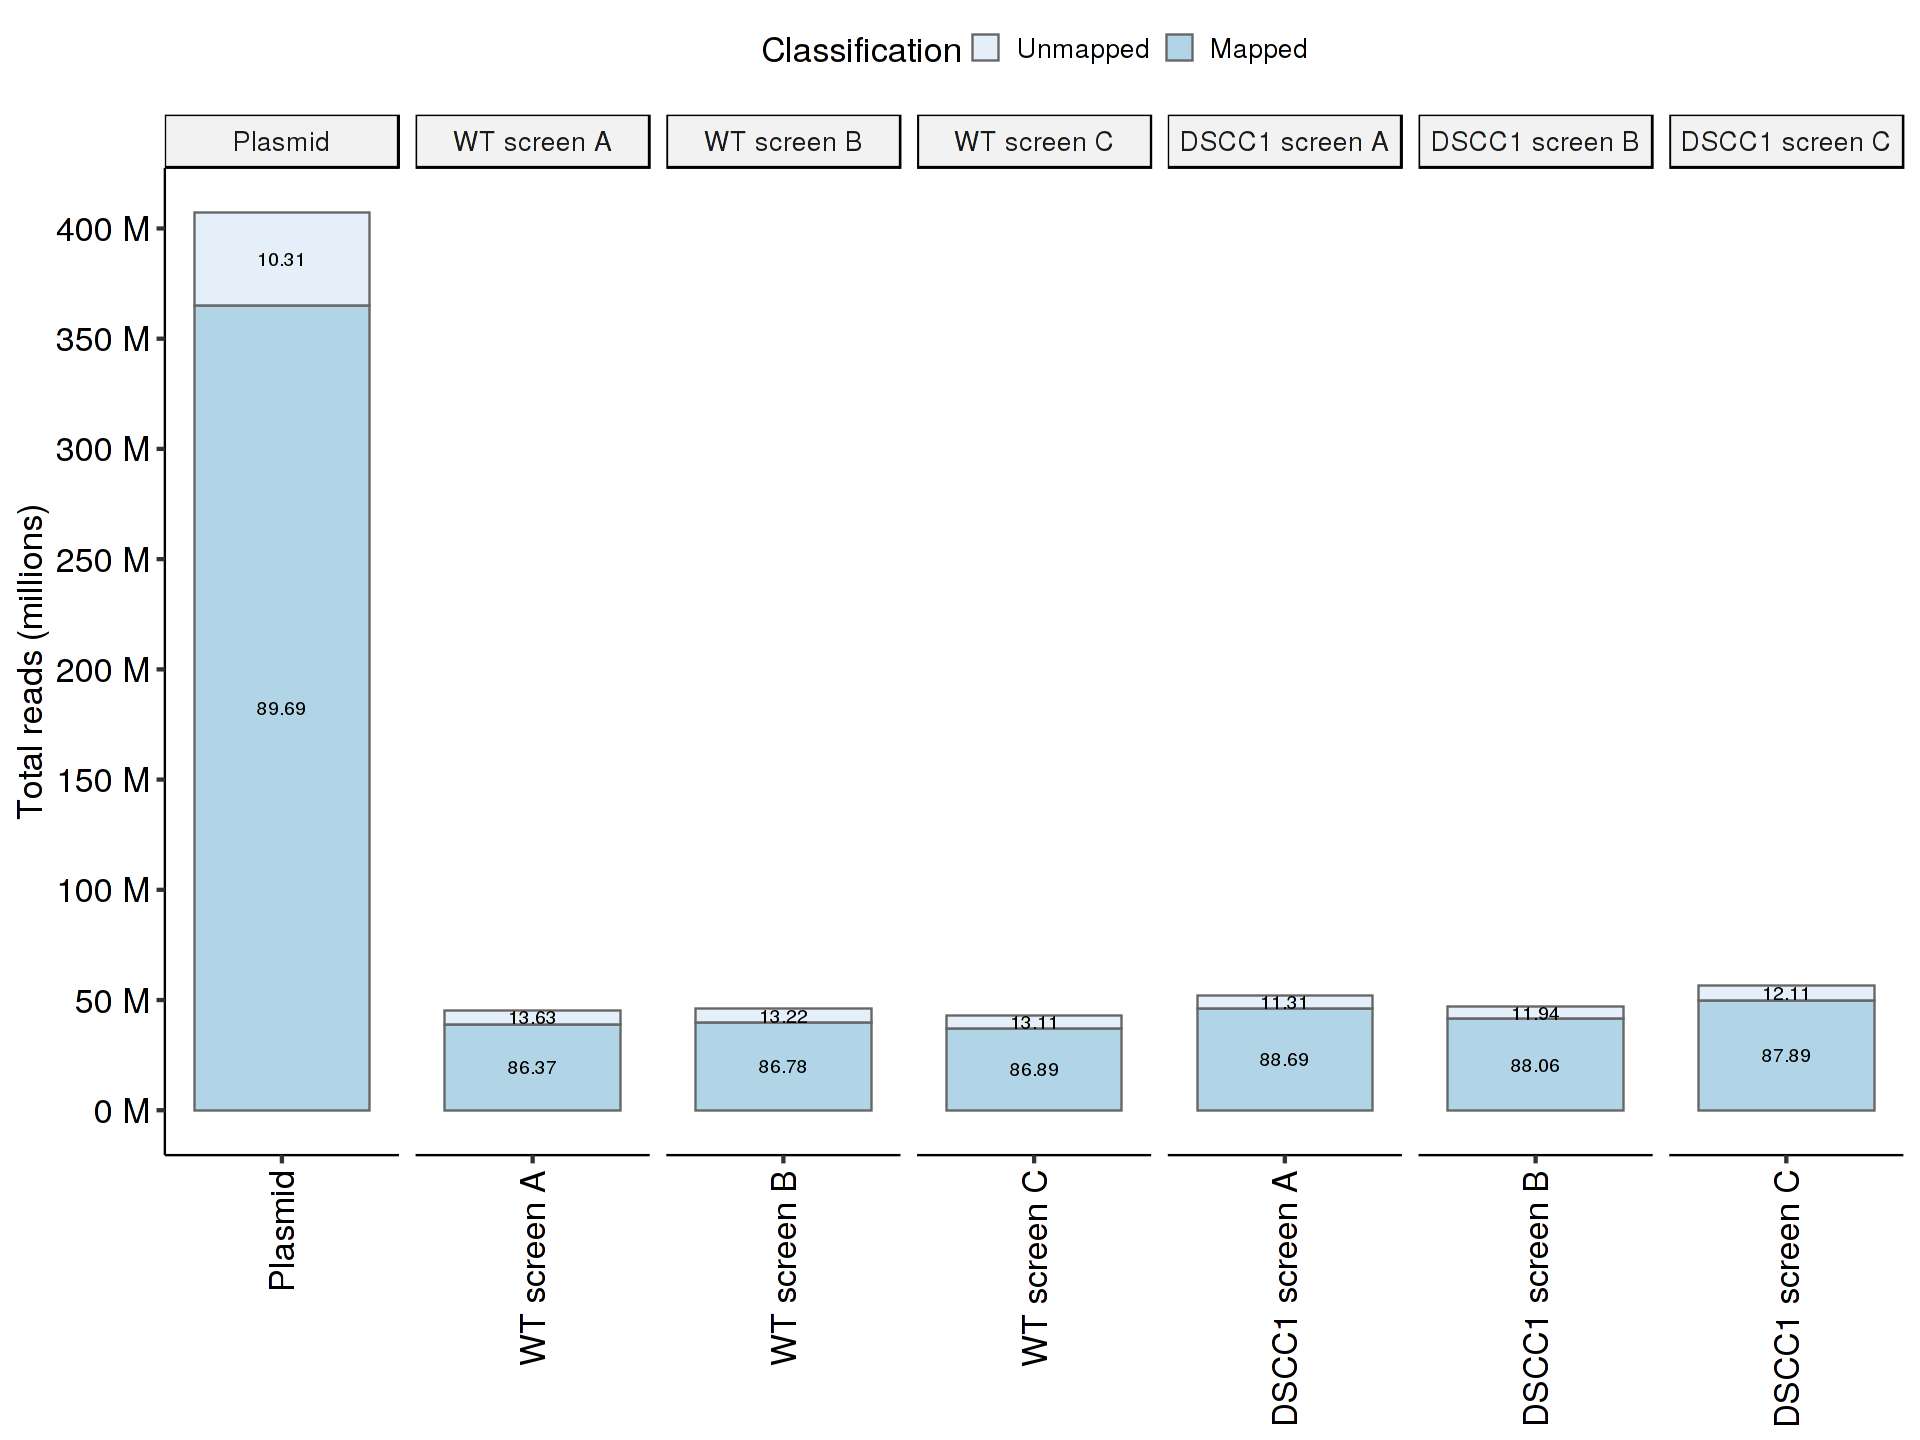

In [9]:

# Prepare mapping statistics for plotting
seq_stats.narrow <- seq_stats |>
    gather(classification, num_reads, -sample_label, -total_reads, -sample_group) |>
    mutate('percentage' = round((num_reads / total_reads) * 100, 2))
seq_stats.narrow$classification <- factor(seq_stats.narrow$classification, 
                                          levels = c('unmapped_reads', 'mapped_reads'))

# Set order of samples for plots
seq_stats.narrow$sample_group <- factor(seq_stats.narrow$sample_group, 
                                        levels = c('Plasmid', 'WT', 'DSCC1'))
seq_stats.narrow$sample_label <- factor(seq_stats.narrow$sample_label, 
                                        levels = c('Plasmid',
                                                   paste('WT screen', c('A', 'B', 'C')),
                                                   paste('DSCC1 screen', c('A', 'B', 'C'))))

# Create mapping plot
mapping_stats_barplot <- 
    ggplot(seq_stats.narrow, aes(y = num_reads, x = sample_label, fill = classification)) + 
        geom_bar(position="stack", stat="identity", color = 'gray40', alpha = 0.8) +
        geom_text(aes(label = percentage), position = position_stack(vjust = 0.5)) +
        facet_grid(. ~ sample_label, scales = 'free_x', space = 'free_x') +
        scale_y_continuous(labels = unit_format(unit = "M", scale = 1e-6), breaks = pretty_breaks(10)) +
        scale_fill_manual(labels=c('Unmapped', 'Mapped'), 
                          values = c('unmapped_reads' = "#DEEBF7", 'mapped_reads' = "#9ECAE1"), 
                          name = 'Classification') +
        ylab('Total reads (millions)') +
        theme_pubr(base_size = 20) +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
              axis.title.x = element_blank()) 

# Save plot
ggsave(filename = 'plots/mapped_vs_unmapped_barplot.png', plot = mapping_stats_barplot,
       device = 'png', width = 10, height = 14, dpi = 200)

# Show plot
mapping_stats_barplot

## Library statistics

Next, we calculate and add library statistics which include:

* proportion of reads assigned to at least one guide
* number of guides with reads assigned (mapped guides)
* number of guides with no reads assigned (zero guides)
* mean and median coverage 
* distribution of guides (Gini index)

In [10]:
# Add function based on MAGeCK code for calculating the Gini index
gini_index <- function(x) {
    xs <- sort(x)
    n <- length(xs)
    gssum <- vector()
    for (i in 1:n) {
        gssum[i] = (i + 1.0) * xs[i]
    }
    gssum <- sum(gssum)
    ysum <- sum(xs)
    if (ysum == 0.0) {
        ysum <- 1.0
    }
    gs <- 1.0 - 2.0 * (n - gssum / ysum) / (n - 1)
    return(gs)   
}

# Calculate library statistics per sample
lib_stats <- raw_counts |>
    gather(sample_label, counts, -sgRNA, -gene) |>
    group_by(sample_label) |>
    summarise(n_guides = n(),
              n_genes = length(unique(gene)),
              zero_guides = sum(counts == 0),
              pct_zero_guides = round((zero_guides/n_guides) * 100, 2),
              lt30_guides = sum(counts < 30),
              max_count = max(counts),
              min_count = min(counts),
              mean_counts = round(mean(counts), 2),
              median_counts = median(counts),
              gini_index = round(gini_index(counts), 2))

# Add to sequencing statistics
summary_stats <- seq_stats |>
    left_join(lib_stats, by = 'sample_label')


# Show data frame
summary_stats

sample_label,sample_group,total_reads,mapped_reads,unmapped_reads,n_guides,n_genes,zero_guides,pct_zero_guides,lt30_guides,max_count,min_count,mean_counts,median_counts,gini_index
<chr>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
DSCC1 screen A,DSCC1,51963205,46084284,5878921,101090,18226,532,0.53,1471,49700,0,455.87,416,0.32
DSCC1 screen B,DSCC1,47107470,41480729,5626741,101090,18226,559,0.55,1761,35475,0,410.33,367,0.34
DSCC1 screen C,DSCC1,56710532,49844705,6865827,101090,18226,518,0.51,1204,56500,0,493.07,458,0.31
Plasmid,Plasmid,407114154,365151667,41962487,101090,18226,143,0.14,430,412425,0,3612.14,3585,0.22
WT screen A,WT,45276397,39103705,6172692,101090,18226,524,0.52,1504,38025,0,386.82,351,0.32
WT screen B,WT,46019093,39934889,6084204,101090,18226,493,0.49,1304,38800,0,395.04,363,0.30
WT screen C,WT,42828627,37214522,5614105,101090,18226,528,0.52,1460,29100,0,368.13,336,0.31


### Zero count guides

Plot the number of guides per sample which could not be assigned to any reads - i.e. the total number of guides which have zero counts.


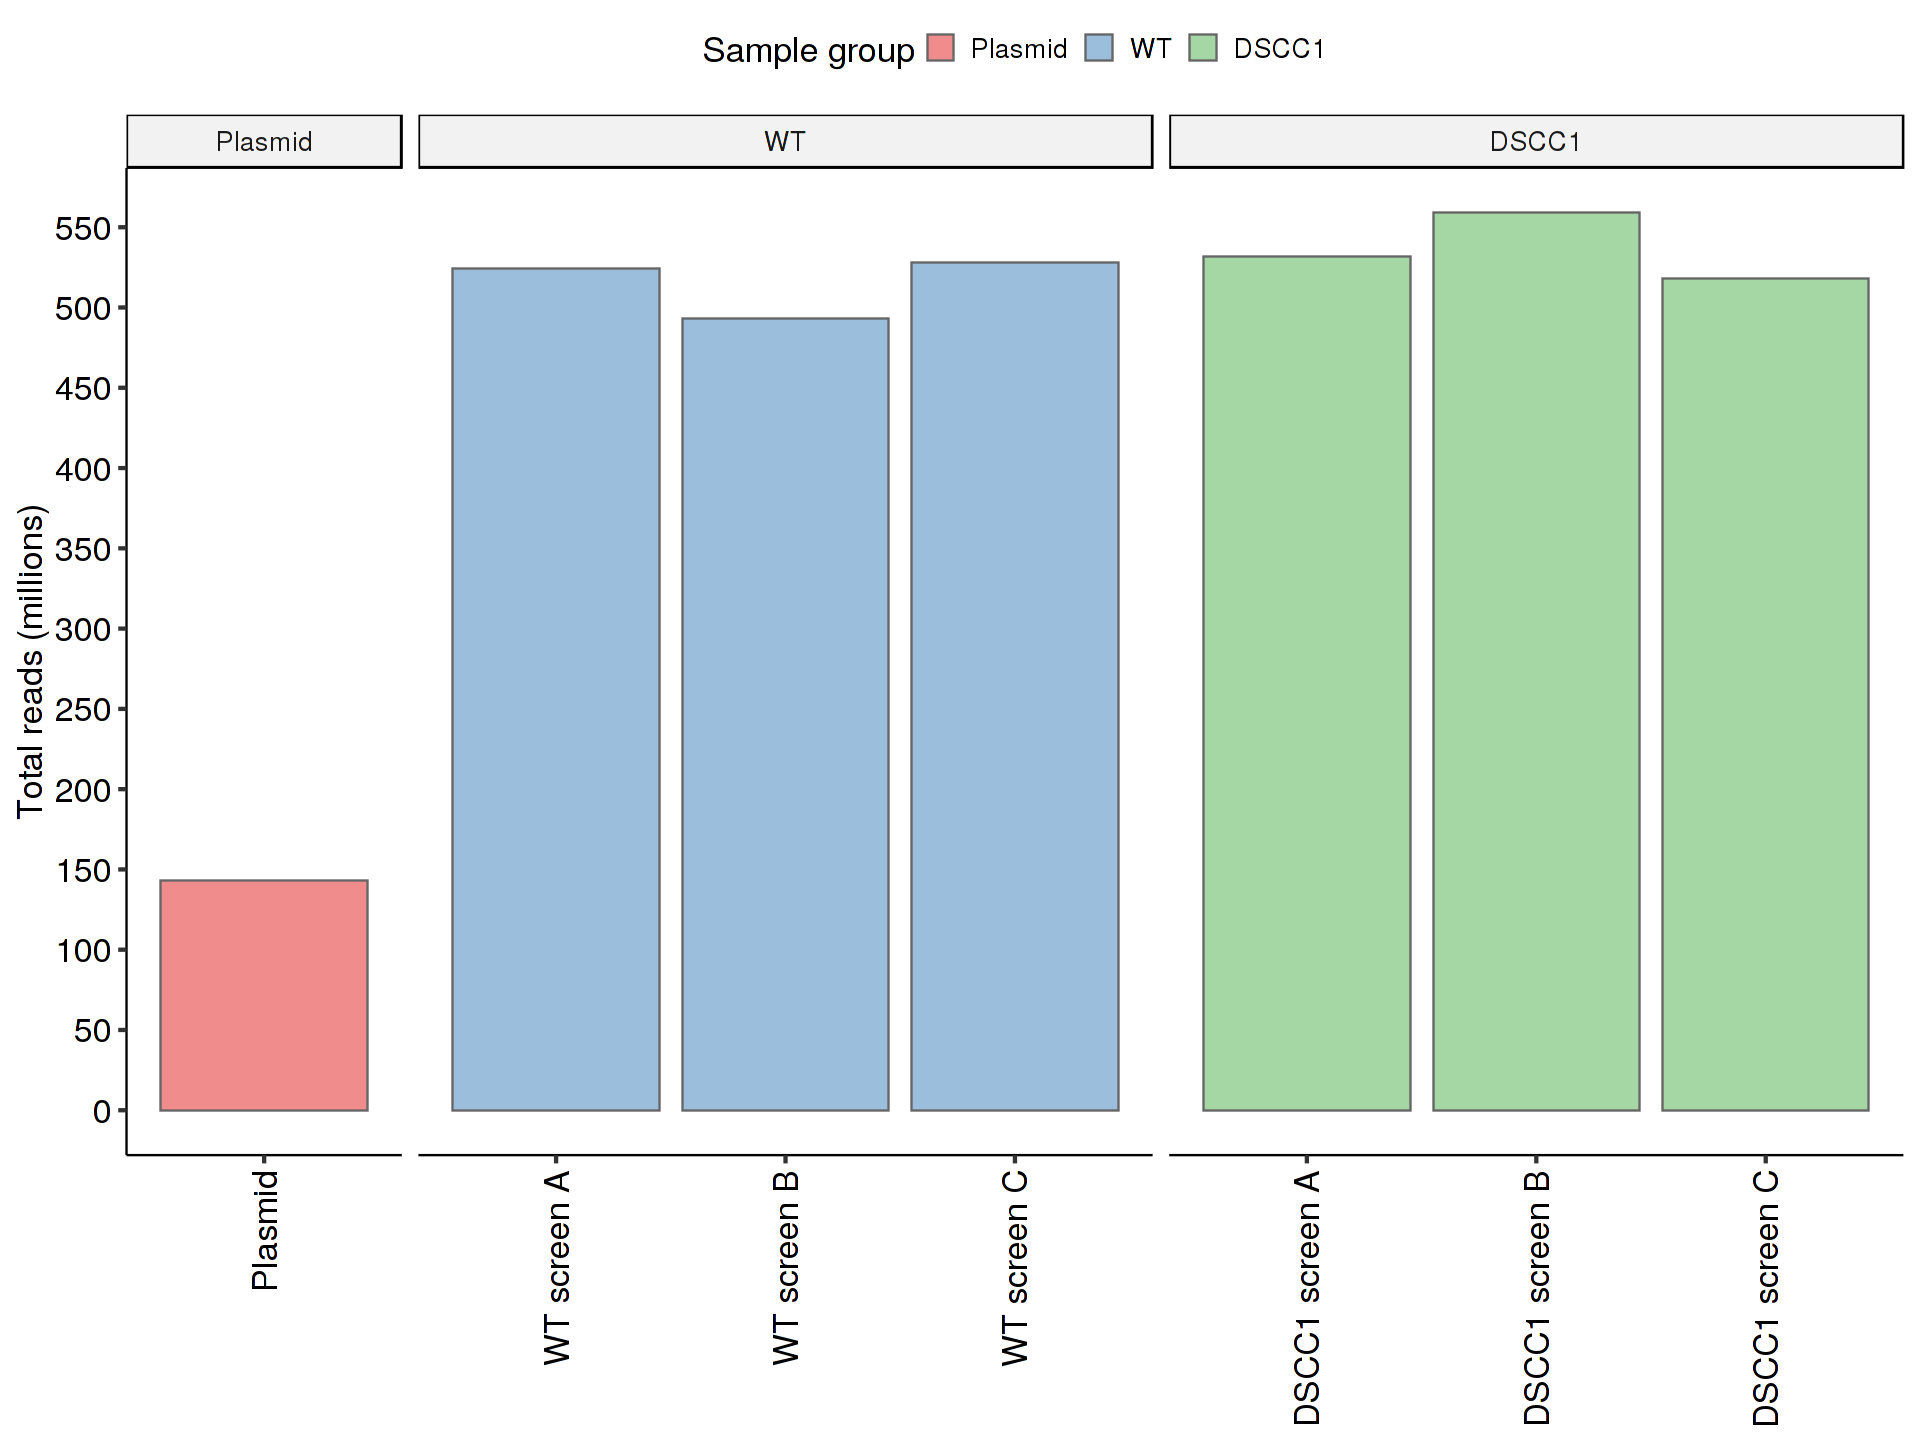

In [11]:
# Plot total reads per sample
zero_count_barplot <-
    ggplot(summary_stats, 
           aes(x = sample_label, y = zero_guides, fill = sample_group)) +
        geom_col(color = 'gray40', alpha = 0.5) +
        scale_y_continuous(breaks = pretty_breaks(9)) +
        scale_fill_manual(name = 'Sample group', values = sample_type_palette) +
        facet_grid(. ~ sample_group, scales = 'free_x', space = 'free_x') +
        ylab('Total reads (millions)') +
        theme_pubr(base_size = 20) +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
              axis.title.x = element_blank()) 

# Save plot
ggsave(filename = 'plots/zero_count_guides_per_sample.png', plot = zero_count_barplot,
       device = 'png', width = 10, height = 10, dpi = 200)

# Show plot
zero_count_barplot

***

### Correlation of replicates

Calculate Spearman correlations and plot correlation of replicates.

In [12]:
# Calculate sample correlations (Spearman)
sample_cor <- cor(raw_counts |> 
                  filter_at(vars(-sgRNA, -gene), all_vars(. < 10000)) |>
                  select(-sgRNA, -gene), method = 'spearman')

# Print correlations
sample_cor

,WT screen A,WT screen B,WT screen C,DSCC1 screen A,DSCC1 screen B,DSCC1 screen C,Plasmid
WT screen A,1.0000000,0.7250699,0.7093654,0.6685329,0.6537193,0.6690770,0.6890539
WT screen B,0.7250699,1.0000000,0.7281137,0.6851543,0.6678333,0.6860158,0.7189119
WT screen C,0.7093654,0.7281137,1.0000000,0.6685869,0.6489289,0.6722949,0.7161942
DSCC1 screen A,0.6685329,0.6851543,0.6685869,1.0000000,0.6615586,0.6879077,0.6614021
DSCC1 screen B,0.6537193,0.6678333,0.6489289,0.6615586,1.0000000,0.6647078,0.6251183
DSCC1 screen C,0.6690770,0.6860158,0.6722949,0.6879077,0.6647078,1.0000000,0.6932384
Plasmid,0.6890539,0.7189119,0.7161942,0.6614021,0.6251183,0.6932384,1.0000000


Show correlation of raw counts as scatter plots (filter to exclude outlier guides with > 1000 reads across all samples).

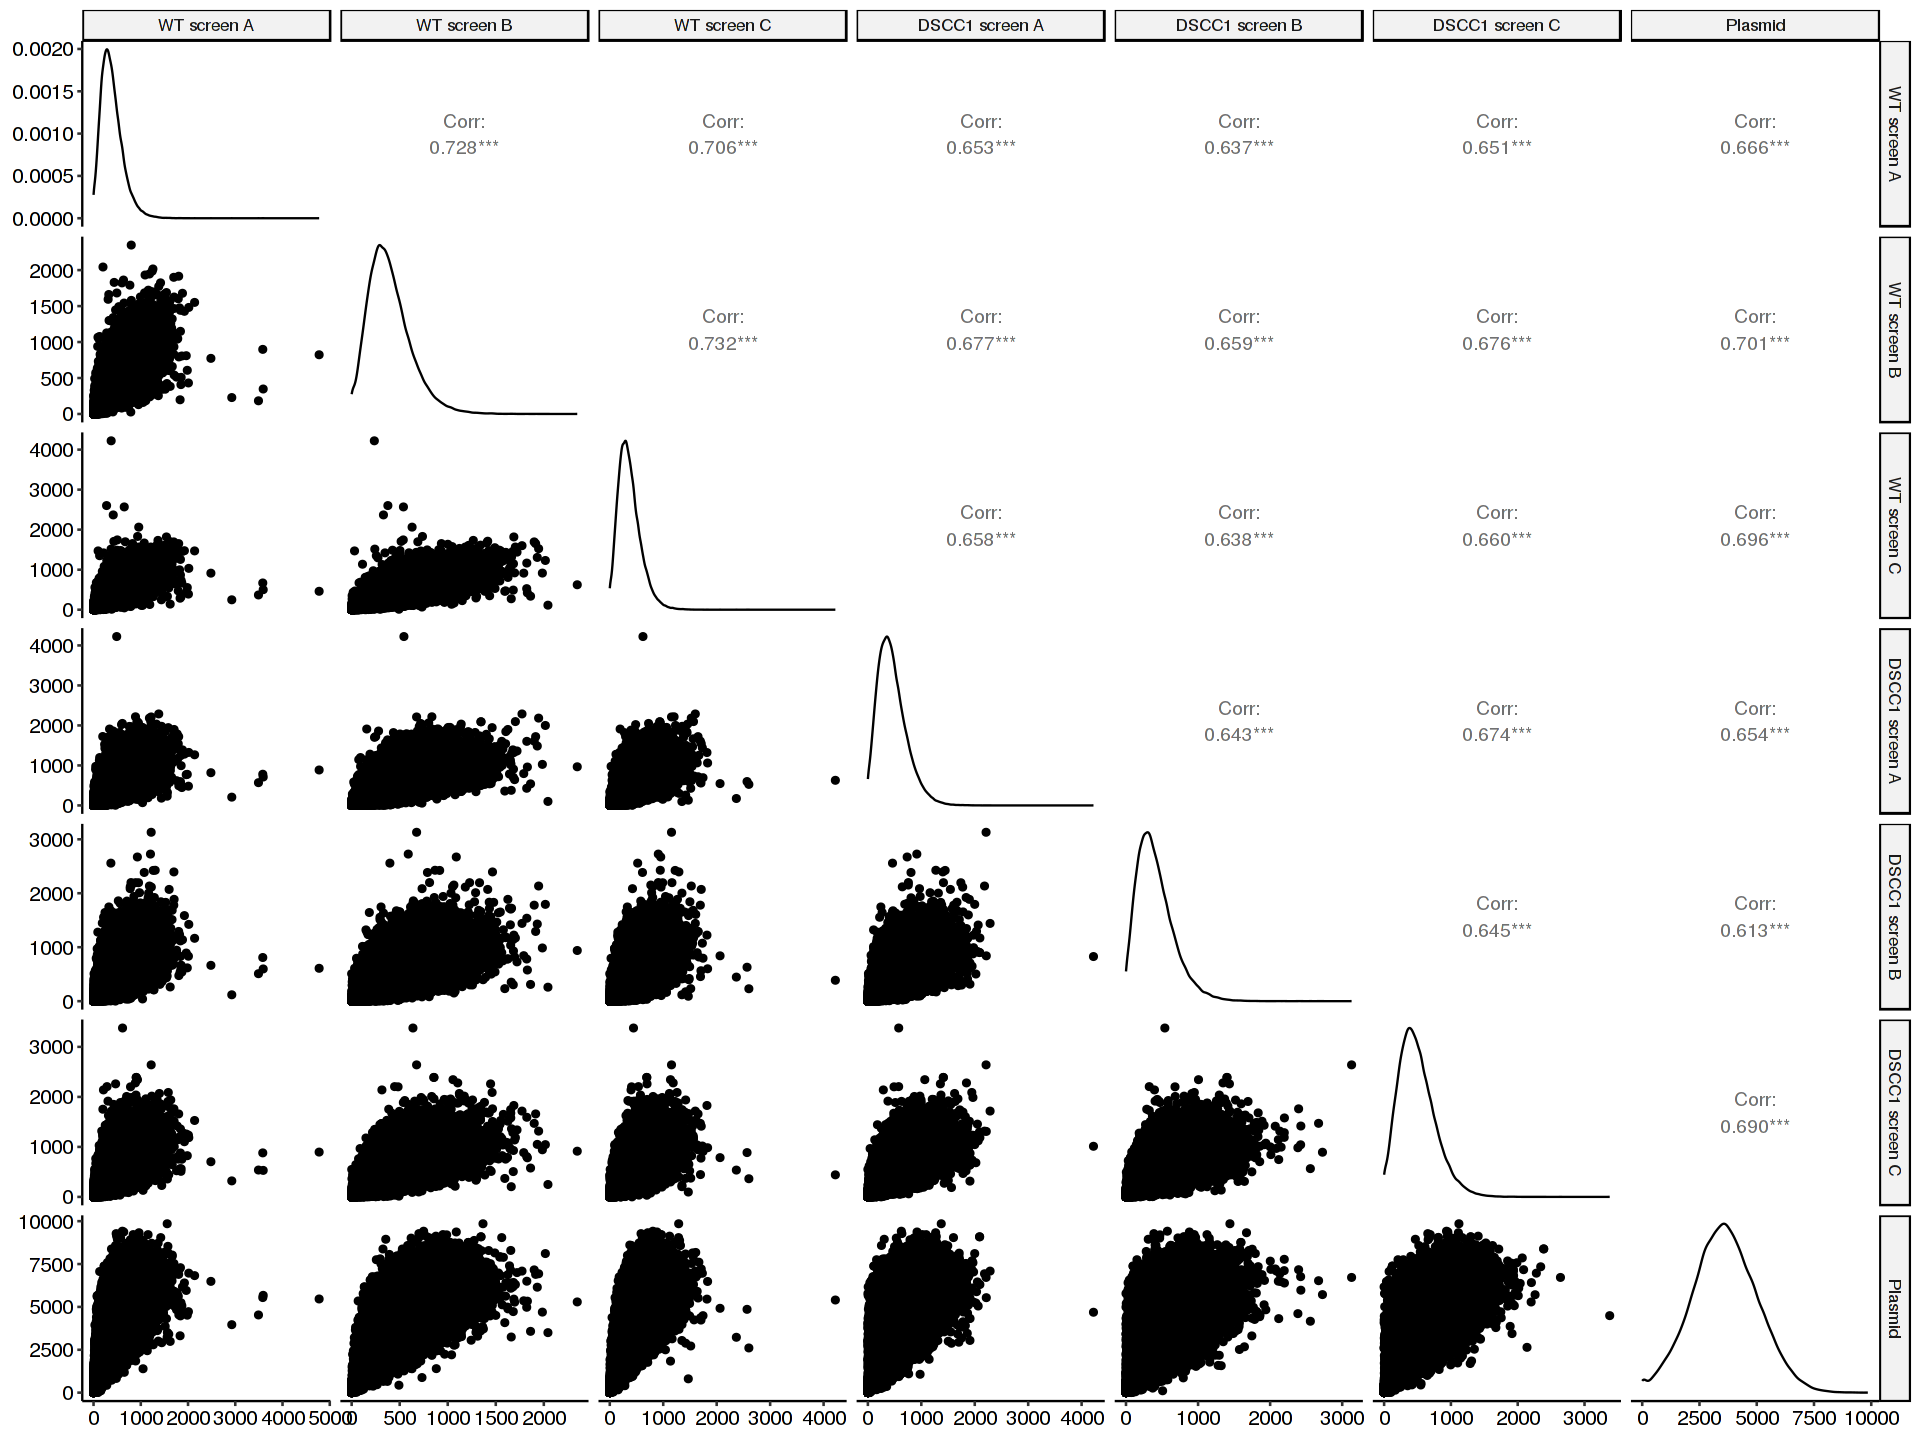

In [13]:
ggpairs(raw_counts |> filter_at(vars(-sgRNA, -gene), all_vars(. < 10000)), columns = 3:9) + 
    theme_pubr()

Show correlation of replicates as a heatmap.

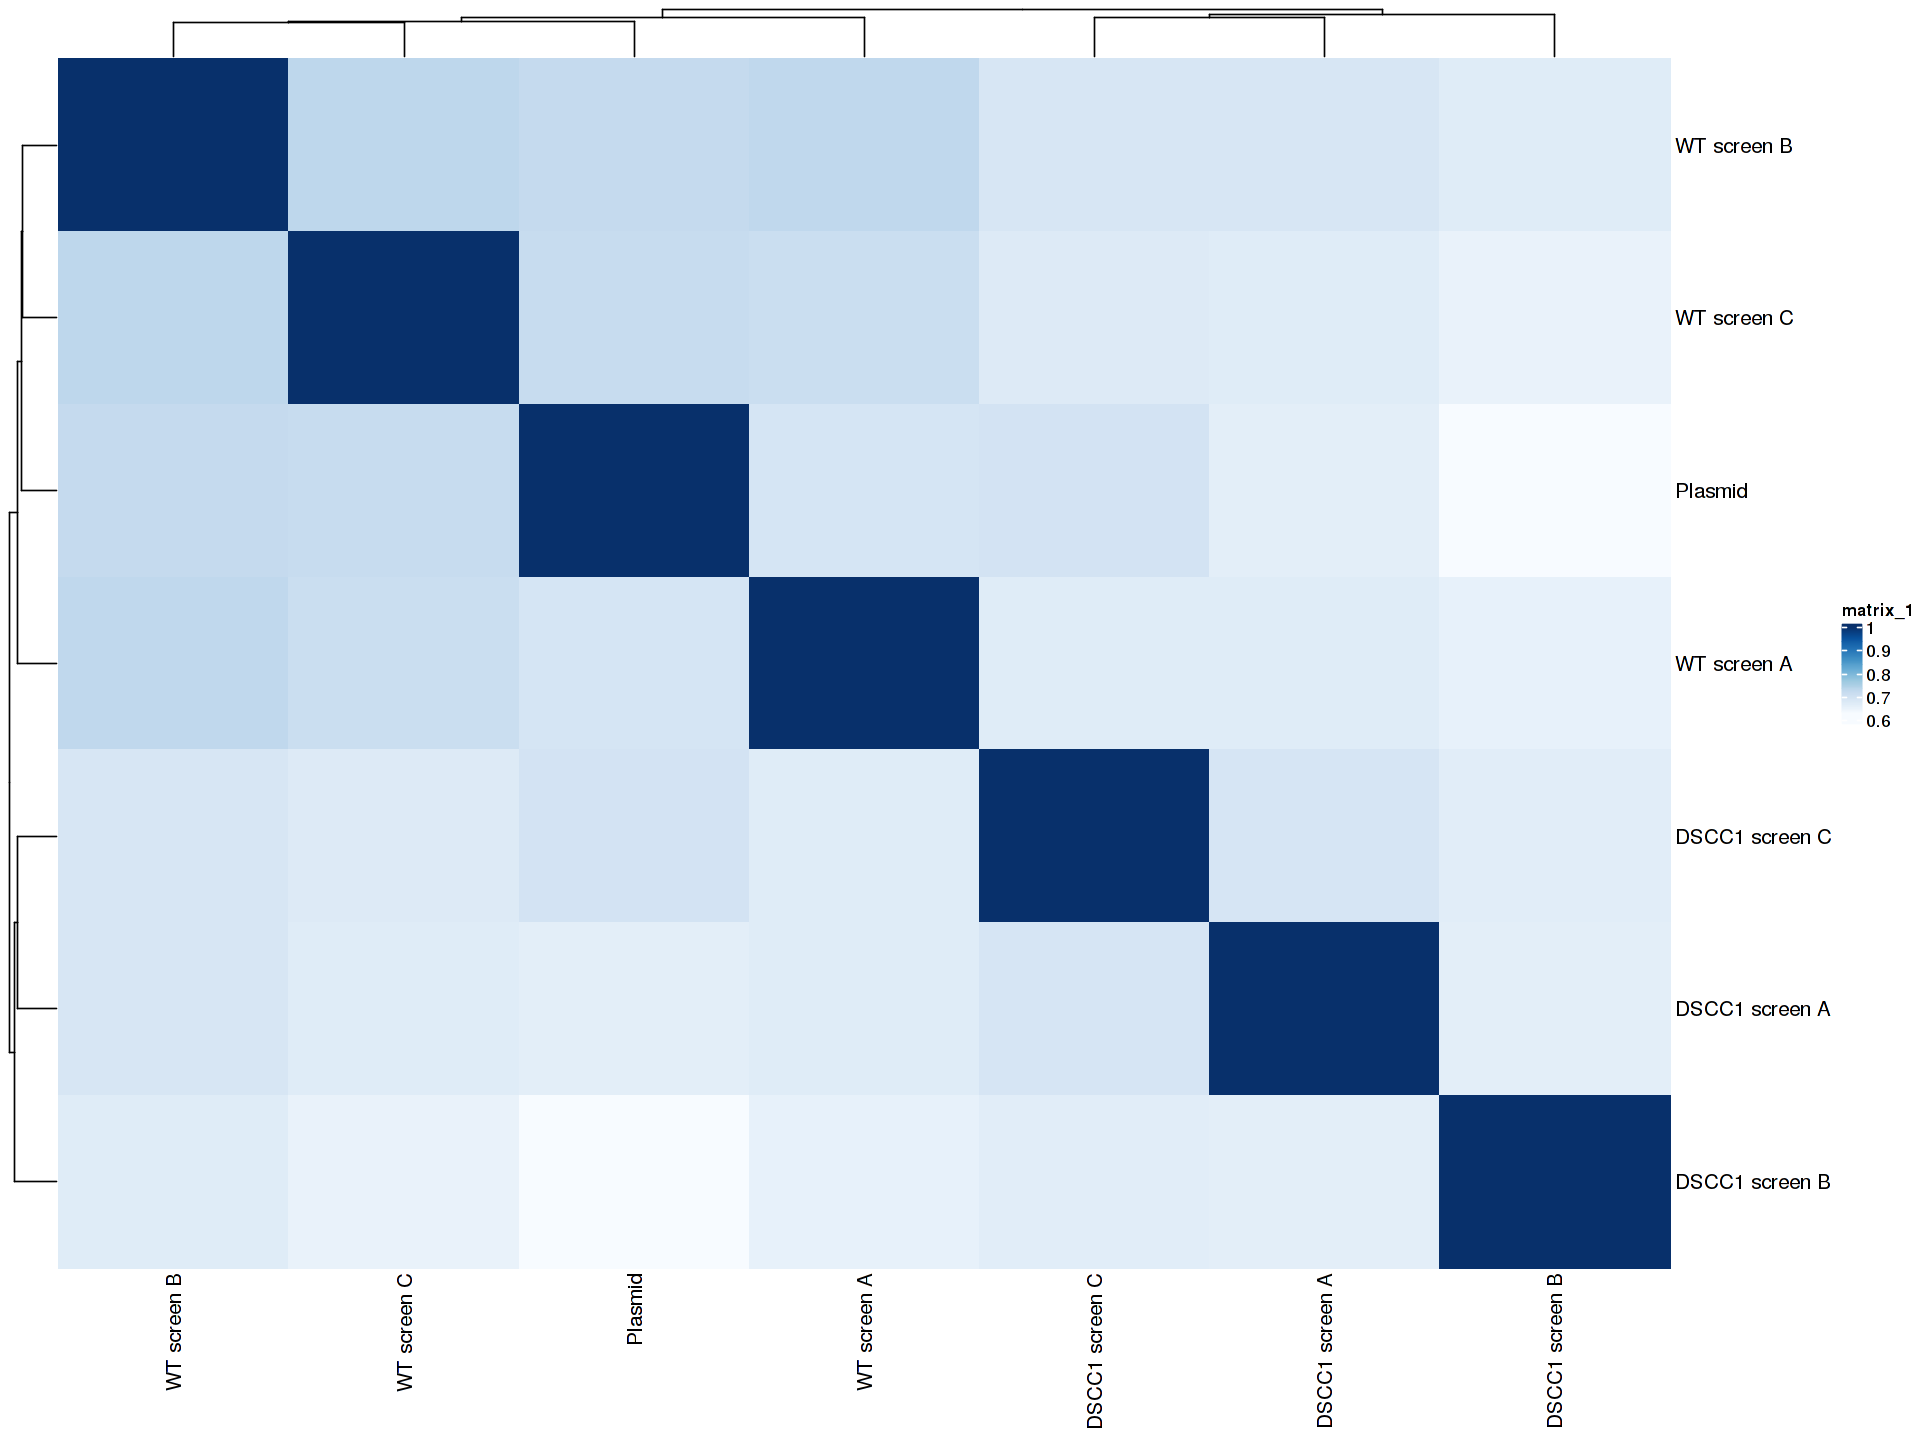

In [14]:
# Set palette
heatmap_cols <- colorRampPalette(brewer.pal(9, "Blues"))(200)

# Plot heatmap of correlations
Heatmap(sample_cor, col = heatmap_cols)

***

## Gene essentiality

Here we look at the separation of BAGEL core essential (CEG) and non-essential genes (NEG) in samples under different conditions.

In [15]:
# Set paths for BAGEL core essential and non-essential genes
ess_file <- 'BAGEL2_f9eedca/gene_lists/bagel_CEGv2_53388ad.txt'
noness_file <- 'BAGEL2_f9eedca/gene_lists/bagel_NEGv1_53388ad.txt'

# Read in essentials and non-essentials
ess <- read.delim(ess_file, header = T, sep = "\t")
noness <- read.delim(noness_file, header = T, sep = "\t")

Next, we read in fold changes (compared to plasmid) which were calculated with BAGEL2.

In [16]:
# Read in BAGEL2 fold changes (samples compared to plasmid)
fc <- read.delim('BAGEL2_f9eedca/results/all_vs_plasmid.foldchange', sep = "\t", header = T)

# Print fold changes
head(fc,3)

,REAGENT_ID,GENE,BOB_screenA,BOB_screenB,BOB_screenC,Dcss1H06_screenA_v2,Dcss1H06_screenB_v2,Dcss1H06_screenC_v2
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1BG_CCDS12976.1_ex3_19:58862927-58862950:-_5-1,A1BG,0.394,-0.186,-0.349,-1.394,0.540,0.095
2,A1BG_CCDS12976.1_ex4_19:58863655-58863678:+_5-2,A1BG,-0.076,0.282,-0.886,0.036,-0.266,-0.454
3,A1BG_CCDS12976.1_ex4_19:58863697-58863720:-_5-3,A1BG,-0.156,-1.225,0.187,-0.256,0.466,-0.073


In [17]:
# Rename columns from sample name to sample label
names(fc)[3:8] <- sample_metadata$sample_label[match(names(fc)[3:8], sample_metadata$sample_name)]

# Print reheadered fold changes
head(fc,3)

,REAGENT_ID,GENE,WT screen A,WT screen B,WT screen C,DSCC1 screen A,DSCC1 screen B,DSCC1 screen C
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1BG_CCDS12976.1_ex3_19:58862927-58862950:-_5-1,A1BG,0.394,-0.186,-0.349,-1.394,0.540,0.095
2,A1BG_CCDS12976.1_ex4_19:58863655-58863678:+_5-2,A1BG,-0.076,0.282,-0.886,0.036,-0.266,-0.454
3,A1BG_CCDS12976.1_ex4_19:58863697-58863720:-_5-3,A1BG,-0.156,-1.225,0.187,-0.256,0.466,-0.073


Now we annotated our genes with the BAGEL2 core gene lists.

In [18]:
# Annotate raw counts
fc.ann <- fc |>
    rowwise() |>
    mutate(classification = case_when(GENE %in% ess$GENE ~ 'essential',
                                      GENE %in% noness$GENE ~ 'non-essential',
                                      grepl('NON-TARGETING', GENE) ~ 'control',
                                      TRUE ~ 'unknown'), .after = 'GENE')

# Make classification a factor
fc.ann$classification <- factor(fc.ann$classification, 
                                levels = c('essential', 'non-essential', 'control', 'unknown'))

# Show data frame
head(fc.ann, 3)

REAGENT_ID,GENE,classification,WT screen A,WT screen B,WT screen C,DSCC1 screen A,DSCC1 screen B,DSCC1 screen C
<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG_CCDS12976.1_ex3_19:58862927-58862950:-_5-1,A1BG,unknown,0.394,-0.186,-0.349,-1.394,0.540,0.095
A1BG_CCDS12976.1_ex4_19:58863655-58863678:+_5-2,A1BG,unknown,-0.076,0.282,-0.886,0.036,-0.266,-0.454
A1BG_CCDS12976.1_ex4_19:58863697-58863720:-_5-3,A1BG,unknown,-0.156,-1.225,0.187,-0.256,0.466,-0.073


In [19]:
# Check annotations
table(fc.ann$classification)


    essential non-essential       control       unknown 
         4606          3612           998         91469 

In [20]:
# Collapse fold changes
fc.narrow <- fc.ann |>
    gather(sample_label, LFC, -REAGENT_ID, -GENE, -classification) |>
    left_join(sample_metadata |> select(sample_label, sample_group), by = 'sample_label') |>
    relocate(sample_group, .after = 'sample_label')

# Show data frame
head(fc.narrow, 3)

REAGENT_ID,GENE,classification,sample_label,sample_group,LFC
<chr>,<chr>,<fct>,<chr>,<fct>,<dbl>
A1BG_CCDS12976.1_ex3_19:58862927-58862950:-_5-1,A1BG,unknown,WT screen A,WT,0.394
A1BG_CCDS12976.1_ex4_19:58863655-58863678:+_5-2,A1BG,unknown,WT screen A,WT,-0.076
A1BG_CCDS12976.1_ex4_19:58863697-58863720:-_5-3,A1BG,unknown,WT screen A,WT,-0.156


Picking joint bandwidth of 0.104

Picking joint bandwidth of 0.117

Picking joint bandwidth of 0.0978

Picking joint bandwidth of 0.093

Picking joint bandwidth of 0.0817

Picking joint bandwidth of 0.0882

Picking joint bandwidth of 0.104

Picking joint bandwidth of 0.117

Picking joint bandwidth of 0.0978

Picking joint bandwidth of 0.093

Picking joint bandwidth of 0.0817

Picking joint bandwidth of 0.0882



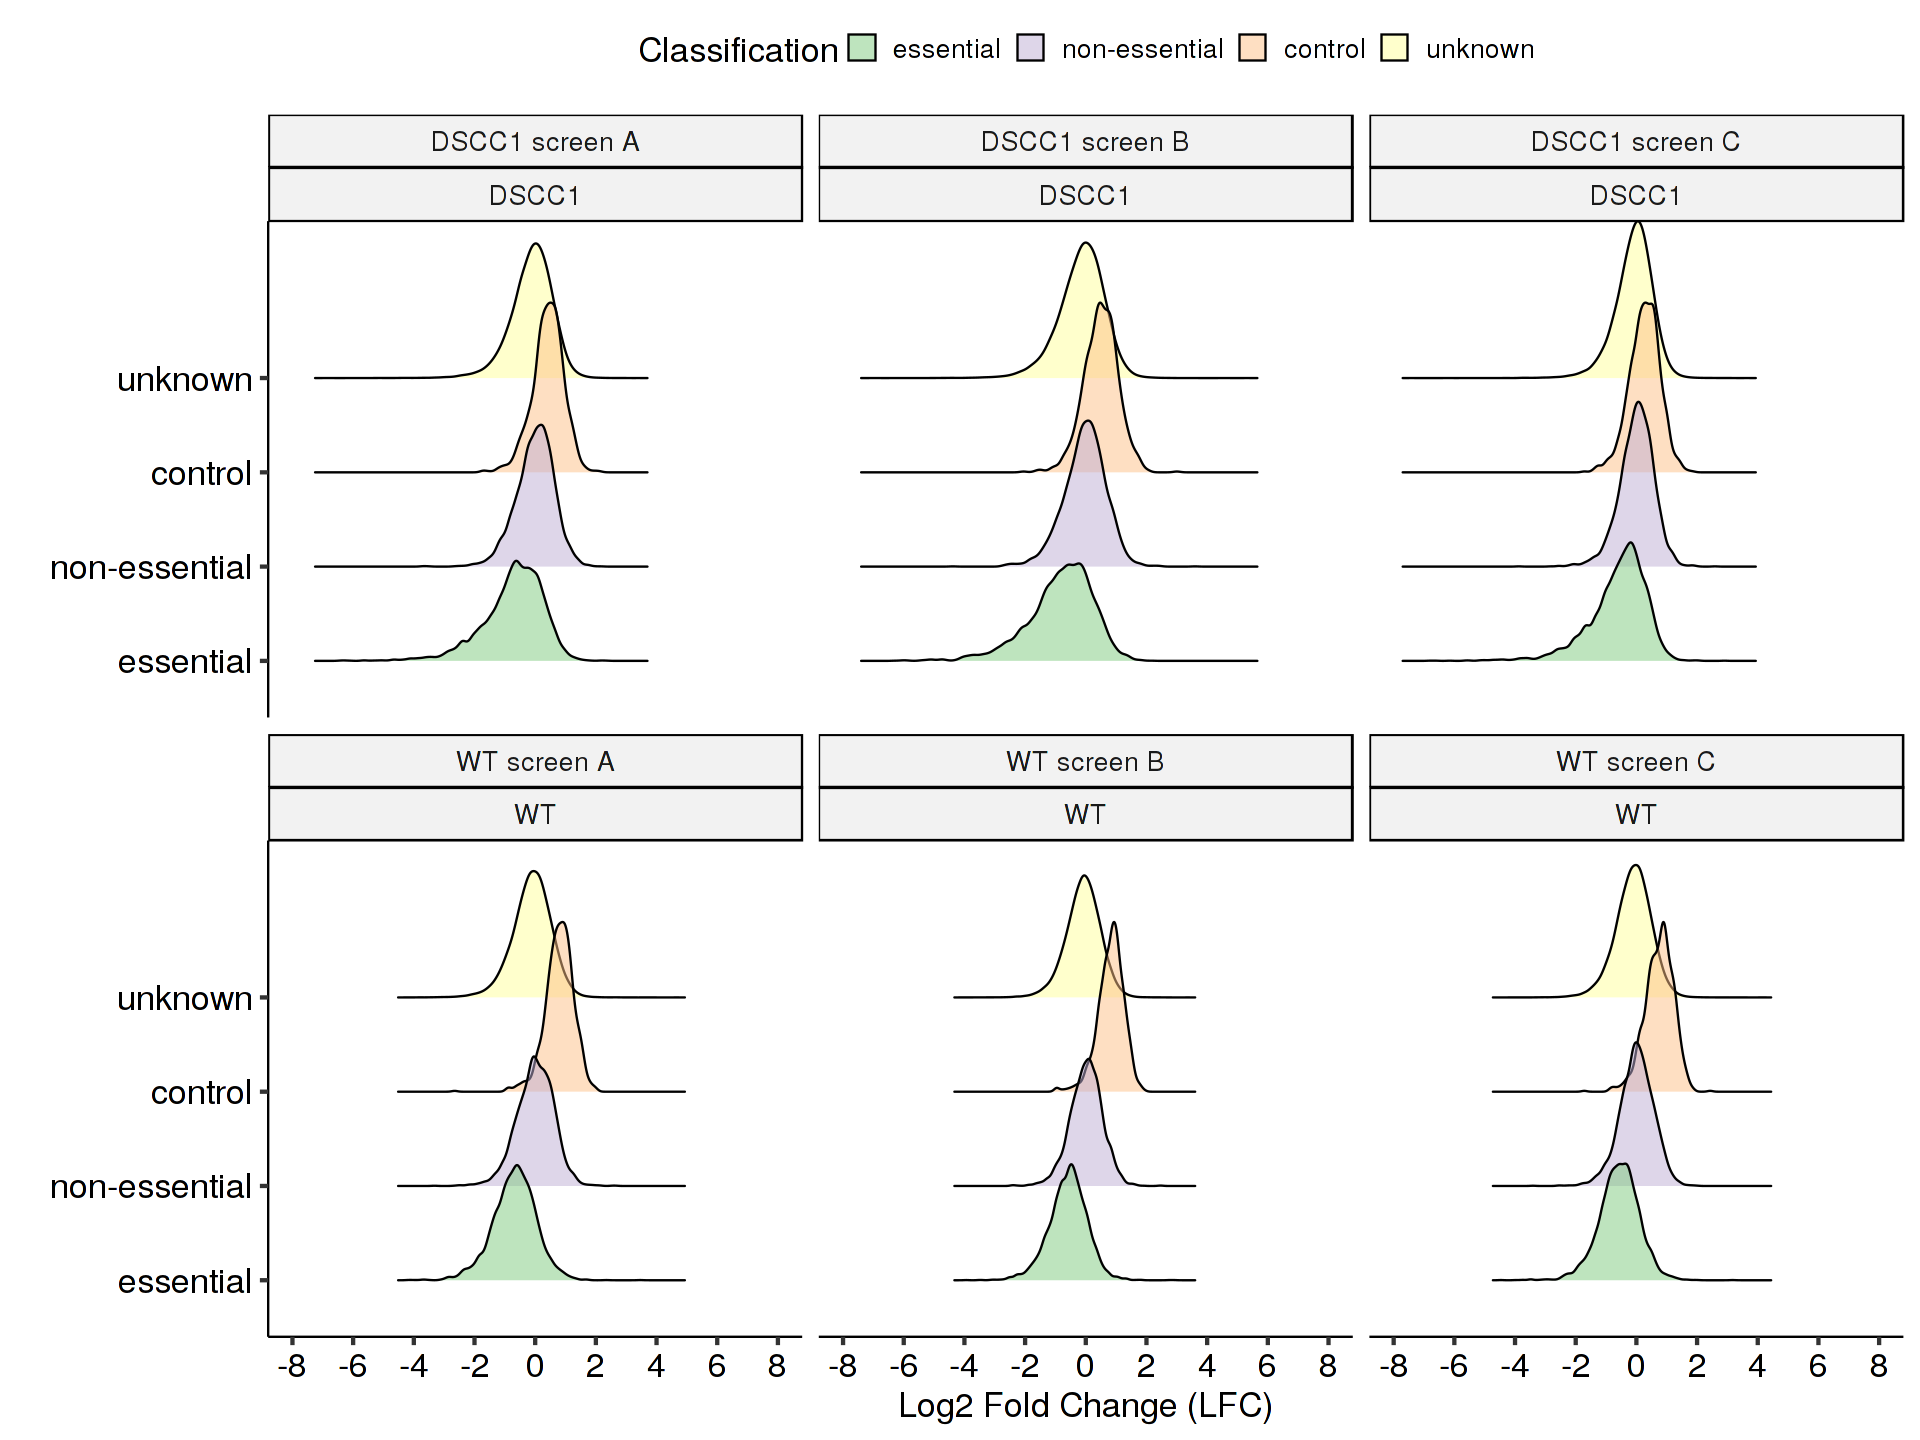

In [21]:
# Classification palette
classification_palette <- brewer.pal(4, 'Accent')
names(classification_palette) <- c('essential', 'non-essential', 'control', 'unknown')

# Plot LFC densities as ridgeline
lfc_density_plot <- 
    ggplot(fc.narrow, aes(x = LFC, y = classification, fill = classification)) +
        geom_density_ridges(alpha = 0.5) +
        facet_wrap(sample_label ~ sample_group) +
        scale_x_continuous(breaks = pretty_breaks(10), limits = c(-8, 8)) +
        scale_fill_manual(values = classification_palette, 
                          name = 'Classification') +
        xlab('Log2 Fold Change (LFC)') +
        ylab('') +
        theme_pubr(base_size = 20) 

# Save plot
ggsave(filename = 'plots/lfc_density.png', plot = lfc_density_plot,
       device = 'png', width = 20, height = 10, dpi = 200)

# Show plot
lfc_density_plot

*** 

### Calculate summary statistics

* **Null-normalized mean difference (NNMD)** - a measure of separation between log fold changes of prior-known essential and non-essentials genes that is defined as the difference in means between log fold changes of essential and non-essential genes divided by standard deviation of log fold changes of the non-essential genes. See [here](https://www.nature.com/articles/s41467-021-21898-7) and [here](https://www.biorxiv.org/content/10.1101/720243v1.full). The more negative the NNMD scores, the better the screen. 
* **Glass' delta** - defined as the mean difference between the essential and non-essential log fold changes divided by the standard deviation of the essential log fold changes. F-test performed to check standard deviations are significantly different.
* **Cohen's d** - defined as the standardized mean difference where a common interpretations are small (0.2), medium (0.6) and large (0.8) although this shouldn't be applied rigidly. Potentially not suitable here due to lack of variance homogeneity.

In [22]:
# Calculate NNMD, Glass' delta and Cohen's d per sample with F-test to check for lack of variance homogeneity
fc_statistics <- fc.narrow |>
    group_by(sample_label, sample_group) |>
    summarise(mean_ess_lfc = mean(LFC[classification == 'essential']), 
              mean_noness_lfc = mean(LFC[classification == 'non-essential']), 
              sd_ess = round(sd(LFC[classification == 'essential']), 2),
              sd_noness = round(sd(LFC[classification == 'non-essential']), 2),
              nnmd = round((mean_ess_lfc - mean_noness_lfc) / sd_noness, 2),
              glass_delta = round((abs(mean_ess_lfc) - mean_noness_lfc) / sd_ess, 2),
              cohen_d = suppressWarnings(round(cohen.d(abs(LFC[classification %in% c('essential', 'non-essential')]) ~ classification[classification %in% c('essential', 'non-essential')])$estimate, 2)),
              ftest = var.test(LFC[classification %in% c('essential', 'non-essential')] ~ classification[classification %in% c('essential', 'non-essential')])$p.value,
              .groups = 'keep') |>
    mutate(mean_ess_lfc = round(mean_ess_lfc, 2)) |>
    mutate(mean_noness_lfc = round(mean_noness_lfc, 2))

# Show data frame
fc_statistics

sample_label,sample_group,mean_ess_lfc,mean_noness_lfc,sd_ess,sd_noness,nnmd,glass_delta,cohen_d,ftest
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DSCC1 screen A,DSCC1,-0.73,-0.01,1.00,0.63,-1.14,0.74,0.62,0
DSCC1 screen B,DSCC1,-0.83,-0.04,1.07,0.70,-1.13,0.81,0.65,0
DSCC1 screen C,DSCC1,-0.61,0.00,0.95,0.57,-1.07,0.64,0.57,0
WT screen A,WT,-0.69,0.00,0.72,0.61,-1.12,0.96,0.63,0
WT screen B,WT,-0.59,0.01,0.64,0.54,-1.11,0.90,0.61,0
WT screen C,WT,-0.57,0.00,0.67,0.56,-1.02,0.84,0.57,0


Write combined statistics to `qc_statistics.tsv`.

In [23]:
# Collate all statistics
all_stats <- summary_stats |> 
    left_join(fc_statistics, by = c('sample_label', 'sample_group'))

# Write to file
write.table(all_stats, 'qc_statistics.tsv', sep = "\t", row.names = F, quote = F)

***

### BAGEL2

BAGEL2 (commit f9eedca) was used to predict essential genes using Bayesian analysis. This was done outside this notebook  with [BAGEL2_f9eedca/bagel_jobscript.sh](BAGEL2_f9eedca/bagel_jobscript.sh) using the [raw_count_matrix.tsv](raw_count_matrix.tsv) as input. 

First, we read in the gene-level results from BAGEL:

* WT vs Plasmid  
* DSCC1 vs Plasmid
* DSCC1 vs WT

In [24]:
# Read in BAGEL2 gene-level Bayes factors
# GENE, BF
bagel_pr <- list(
    'WT vs Plasmid' = read.delim('BAGEL2_f9eedca/results/WT_vs_plasmid.pr', header = T, sep = "\t"),
    'DSCC1 vs Plasmid' = read.delim('BAGEL2_f9eedca/results/DSCC1_vs_plasmid.pr', header = T, sep = "\t"),
    'DSCC1 vs WT' = read.delim('BAGEL2_f9eedca/results/DSCC1_vs_WT.pr', header = T, sep = "\t"))

# Read in BAGEL2 gene-level precision-recall results
# Gene, BF, Recall, Precision, FDR
bagel_bf <- list(
    'WT vs Plasmid' = read.delim('BAGEL2_f9eedca/results/WT_vs_plasmid.gene.bf', header = T, sep = "\t"),
    'DSCC1 vs Plasmid' = read.delim('BAGEL2_f9eedca/results/DSCC1_vs_plasmid.gene.bf', header = T, sep = "\t"),
    'DSCC1 vs WT' = read.delim('BAGEL2_f9eedca/results/DSCC1_vs_WT.gene.bf', header = T, sep = "\t"))

Next we generate an ROC object using pROC to get the area under the curve (AUC).

In [25]:
# Build ROC object inputs using BAGEL2 results and essentiality information from gene lists
essentiality_data <- list()
for (contrast in c('WT vs Plasmid', 'DSCC1 vs Plasmid', 'DSCC1 vs WT')) {
    all_genes <- unique(bagel_bf[[contrast]]$GENE)
    essential_genes <- fc.ann |> filter(classification == 'essential') |> pull(GENE) |> unique()
    # Essential = 1, Non-essential = 0
    essentiality <- rep(0, length(all_genes))
    names(essentiality) <- all_genes
    essentiality[essential_genes] <- 1

    # Get predicted values for each observation
    essentiality_data[[contrast]][['essentiality']] <- essentiality
    essentiality_data[[contrast]][['predictor']] <- bagel_bf[[contrast]] |> filter(GENE %in% all_genes) |> pull(BF)
    essentiality_data[[contrast]][['min']] <- min(essentiality_data[[contrast]][['predictor']], na.rm = TRUE)
    essentiality_data[[contrast]][['modified_predictor']] <-  essentiality_data[[contrast]][['predictor']] - essentiality_data[[contrast]][['min']]
}

In [26]:
# Get ROC object and extract AUC for each contrast
auc <- data.frame()
roc_list <- list()
for (contrast in c('WT vs Plasmid', 'DSCC1 vs Plasmid', 'DSCC1 vs WT')) {
    screen_roc <- roc(essentiality_data[[contrast]][['essentiality']],
                      essentiality_data[[contrast]][['modified_predictor']])
    roc_list[[contrast]] <- screen_roc
    auc <- rbind(auc, data.frame('contrast' = contrast, 
                                 'AUC' = round(as.numeric(screen_roc['auc']), 2)))
}

# Show data frame
auc

# Write to table
write.table(auc, 'bagel_auc_qc_statistics.tsv', sep = "\t", row.names = F, quote = F)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases



contrast,AUC
<chr>,<dbl>
WT vs Plasmid,0.94
DSCC1 vs Plasmid,0.89
DSCC1 vs WT,0.55


In [27]:
# Plot ROC
png(file = 'plots/bagel_roc.png', width = 2000, height = 2000, res = 300)
    plot(roc_list[['WT vs Plasmid']], print.auc = TRUE, col = "navyblue", cex.lab = 1.5, cex.axis = 1.2, cex.text = 1.5, grid = T)
    plot(roc_list[['DSCC1 vs Plasmid']], print.auc = TRUE, col = "forestgreen", print.auc.y = .45, add = TRUE)
    legend("bottomright",
           legend=c("WT vs Plasmid", "DSCC1 vs Plasmid"),
           col=c("navyblue", "forestgreen"),
           lty=c(1,3),
           lwd=c(2,2),
           cex=1.3)
dev.off()

png 
  2

Finally, we get a list of genes which are significantly essential (depleted) in DSCC1 vs plasmid and also essential (depleted) in DSCC1 vs WT. This can be done from the BAGEL2 `pr` output which gives FDR as well as the precision/recall for plotting. 

In [28]:
# Get list of genes which are both depleted in DSCC1 vs plasmid and DSCC1 vs WT
dscc1_vs_plasmid.sig <- bagel_pr[['DSCC1 vs Plasmid']] |> filter(FDR < 0.05)
dscc1_vs_wt.sig <- bagel_pr[['DSCC1 vs WT']] |> filter(FDR < 0.05)
shared.sig <- dscc1_vs_wt.sig |> filter(Gene %in% dscc1_vs_plasmid.sig$Gene) |> arrange(-BF)

# Show number of genes
print(paste('Number of depleted genes:', nrow(shared.sig)))

# Show gene list
head(shared.sig, 10)

# Write gene list
write.table(shared.sig, 'bagel_depleted_genes.tsv', sep = "\t", row.names = F, quote = F)

[1] "Number of depleted genes: 146"


,Gene,BF,Recall,Precision,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,RPS3A,32.344,0.000,1,0
2,CDC27,30.930,0.002,1,0
3,DNAJC9,25.230,0.003,1,0
4,RPS18,24.813,0.005,1,0
5,RPL23A,24.739,0.005,1,0
6,HIST1H2BC,23.883,0.005,1,0
7,RPL18,22.749,0.006,1,0
8,RPL6,22.356,0.008,1,0
9,RPL9,21.850,0.008,1,0
